In [3]:
using LinearAlgebra
using Distributions
using HDF5
using Base

In [4]:
include("../../theory/osc.jl")

Main.osc

In [5]:
h5file = h5open("dataRelease.h5", "r");

In [6]:
datasets = Dict()
smearings = Dict()
channels = ["FDCC", "FDNC", "NDCC", "NDNC"]

4-element Vector{String}:
 "FDCC"
 "FDNC"
 "NDCC"
 "NDNC"

In [7]:
@kwdef struct dataset
    energy_edges::AbstractVector
    observed::AbstractVector
end

dataset

In [8]:
@kwdef struct smearing
    LoverE::AbstractVector
    energy_edges::AbstractVector
    NuMu::AbstractMatrix
    TrueNC::AbstractMatrix
    BeamNue::AbstractMatrix
    AppNue::AbstractMatrix
    AppNuTau::AbstractMatrix
end

smearing

In [9]:
channel = "FDCC"
experiments = ["minos", "minosPlus"]

2-element Vector{String}:
 "minos"
 "minosPlus"

In [10]:
for channel in channels
    datasets[channel] = dataset(
        energy_edges=read(h5file["data$(channel)_minosPlus_bins"]),
        observed=sum([read(h5file["data$(channel)_$(ex)_hist"]) for ex in experiments])
    )
    
    smearings[channel] = smearing(
        LoverE=read(h5file["hRecoToTrue$(channel)SelectedNuMu_minos_bins1"]),
        energy_edges=read(h5file["hRecoToTrue$(channel)SelectedNuMu_minos_bins2"]),
        NuMu=sum([read(h5file["hRecoToTrue$(channel)SelectedNuMu_$(ex)_hist"]) for ex in experiments]),
        TrueNC=sum([read(h5file["hRecoToTrue$(channel)SelectedTrueNC_$(ex)_hist"]) for ex in experiments]),
        BeamNue=sum([read(h5file["hRecoToTrue$(channel)SelectedBeamNue_$(ex)_hist"]) for ex in experiments]),
        AppNue=sum([read(h5file["hRecoToTrue$(channel)SelectedAppNue_$(ex)_hist"]) for ex in experiments]),
        AppNuTau=sum([read(h5file["hRecoToTrue$(channel)SelectedAppNuTau_$(ex)_hist"]) for ex in experiments])
    )
end

In [82]:
TotalCCCovar = (x->reshape(x, fill(Int(sqrt(length(x))), 2)...))(read(h5file["TotalCCCovar"]));

In [77]:
fill(Int(sqrt(4)), 2)

2-element Vector{Int64}:
 2
 2

In [83]:
read(h5file["TotalCCCovar"]) |> x->reshape(x, fill(Int(sqrt(length(x))), 2)...)

91×91 Matrix{Float64}:
 0.0243029   0.0214039   0.0203294   …  0.00273473  0.00295298  0.00320074
 0.0214039   0.0224725   0.0215622      0.00355685  0.00376495  0.00400956
 0.0203294   0.0215622   0.0220683      0.00352442  0.00371731  0.00394451
 0.0192932   0.0210933   0.0212825      0.00361049  0.00379259  0.00400772
 0.0184389   0.0206243   0.0209569      0.00375065  0.00392465  0.00413093
 0.0177161   0.0201451   0.0205659   …  0.00393389  0.00410552  0.00430999
 0.0170268   0.0196518   0.0201451      0.0041084   0.00428039  0.00448629
 0.0162736   0.0190654   0.0196221      0.00431762  0.0044881   0.00469249
 0.0153671   0.0183207   0.0189493      0.00450604  0.00466844  0.00486219
 0.0143223   0.017431    0.0181388      0.00468888  0.00483808  0.00501441
 0.0132481   0.0165206   0.0173103   …  0.00491384  0.00504939  0.00520723
 0.012133    0.0155638   0.0164347      0.00512682  0.00524857  0.00538788
 0.0110262   0.0146052   0.0155518      0.00537667  0.00548602  0.00560807
 ⋮

In [12]:
TotalNCCovar = let
    cov = read(h5file["TotalNCCovar"])
    n = Int(sqrt(length(cov)))
    reshape(cov, n, n)
end;

In [13]:
params = Dict()
params[:θ₁₂] = asin(sqrt(0.307))
params[:θ₁₃] = asin(sqrt(0.021))
params[:θ₂₃] = asin(sqrt(0.57)) #49.2 / 180 * np.pi
params[:δCP] = 1.
params[:Δm²₂₁] = 7.53e-5
params[:Δm²₃₁] = 2.4e-3 + params[:Δm²₂₁]

n = NamedTuple(params)

(Δm²₃₁ = 0.0024752999999999997, θ₁₂ = 0.5872523687443223, θ₂₃ = 0.8556288707523761, Δm²₂₁ = 7.53e-5, θ₁₃ = 0.1454258194533693, δCP = 1.0)

In [84]:
function get_expected_per_channel(params, osc_prob, channel)
    # Minos baseline:
    L = 735.
    #density = np.array([2.84,])
    s = smearings[channel]
    LoverE_avg = (smearings[channel].LoverE[1:end-1] .+ smearings[channel].LoverE[2:end]) ./ 2
    p = osc_prob(L ./ LoverE_avg, [L], params)
    NuMu = s.NuMu * p[:,[1],2,2]
    TrueNC = s.TrueNC * dropdims(sum(p[:,[1],2,1:3], dims=3), dims=3)
    BeamNue = s.BeamNue * p[:,[1],1,1]
    AppNue = s.AppNue * p[:,[1],2,1]
    AppNuTau = s.AppNuTau * p[:,[1],2,3]
    dropdims(NuMu + TrueNC + BeamNue + AppNue + AppNuTau, dims=2)
end

get_expected_per_channel (generic function with 1 method)

In [93]:
function forward_model_per_channel(params, osc_prob, channel)
    println(channel)
    observed = datasets["FD"*channel].observed
    expected = get_expected_per_channel(params, osc_prob, "FD"*channel)
    observed_near = datasets["ND"*channel].observed
    expected_near = get_expected_per_channel(params, osc_prob, "ND"*channel)

    if channel == "CC"
        cov = TotalCCCovar
    else
        cov = TotalNCCovar
    end

    tot = vcat(expected, expected_near)
    cov = (tot * tot') .* cov + diagm(tot)
        
    cov11 = cov[1:length(observed), 1:length(observed)]
    cov12 = cov[1:length(observed), end-length(observed_near)+1:end]
    cov21 = cov[end-length(observed_near)+1:end, 1:length(observed)]
    cov22 = cov[end-length(observed_near)+1:end, end-length(observed_near)+1:end]

    cov22inv = inv(cov22)

    x = cov12 * (cov22inv * (observed_near - expected_near))
    expected = expected + x

    cov = cov11 - cov12 * cov22inv * cov21

    Distributions.MvNormal(expected, (cov+cov')/2)
end

forward_model_per_channel (generic function with 1 method)

In [94]:
function forward_model(params, osc_prob)
    [forward_model_per_channel(params, osc_prob, channel) for channel in ["CC", "NC"]]
end

forward_model (generic function with 1 method)

In [88]:
observed = [datasets[channel].observed for channel in channels[1:2]]

2-element Vector{Vector{Float64}}:
 [13.0, 9.0, 9.0, 19.0, 30.0, 44.0, 47.0, 86.0, 109.0, 151.0  …  102.0, 80.0, 80.0, 127.0, 100.0, 87.0, 78.0, 55.0, 115.0, 101.0]
 [47.0, 256.0, 205.0, 189.0, 183.0, 194.0, 182.0, 187.0, 173.0, 136.0  …  102.0, 76.0, 52.0, 37.0, 28.0, 40.0, 35.0, 22.0, 11.0, 12.0]

In [89]:
params

Dict{Any, Any} with 6 entries:
  :Δm²₃₁ => 0.0024753
  :θ₁₂   => 0.587252
  :θ₂₃   => 0.855629
  :Δm²₂₁ => 7.53e-5
  :θ₁₃   => 0.145426
  :δCP   => 1.0

In [95]:
ps = forward_model(n, osc.osc_prob)

2-element Vector{FullNormal}:
 FullNormal(
dim: 44
μ: [8.433970993875867, 7.87728455289695, 9.750764508962884, 15.151160128241896, 26.783615312401693, 43.595954521986265, 64.41092175993155, 85.85574258801894, 107.6121548324717, 126.39091959608044  …  88.5230230627803, 79.244805123632, 71.07384102575989, 122.40679474518672, 99.80152010903811, 82.55625928104399, 67.123952593403, 56.140891418611346, 87.85806371899132, 91.47054243508245]
Σ: [7.123246435962535 0.11447780545202424 … -0.09074210977087371 -0.06422150268532223; 0.11447780545202424 6.741161418729107 … -0.09718754700680343 -0.10859475197490243; … ; -0.09074210977087371 -0.09718754700680343 … 82.54184801232822 2.687682460524634; -0.06422150268532223 -0.10859475197490243 … 2.687682460524634 85.60530191636519]
)

 FullNormal(
dim: 27
μ: [38.889259473009666, 224.22118696979956, 195.7154662373822, 179.92003062659307, 175.63905678107358, 178.1303788440417, 181.31559878015528, 177.3156539364464, 163.53619577654666, 147.46009230674835  …

In [96]:
sum(logpdf.(forward_model(n, osc.osc_prob), observed))

-268.4046154382644

In [20]:
p2 = deepcopy(params)
p2[:Δm²₃₁] = 0.03
n2 = NamedTuple(p2)

(Δm²₃₁ = 0.03, θ₁₂ = 0.5872523687443223, θ₂₃ = 0.8556288707523761, Δm²₂₁ = 7.53e-5, θ₁₃ = 0.1454258194533693, δCP = 1.0)

In [58]:
sum(logpdf.(forward_model(n2, osc.osc_prob), observed))

-3794.822062192382

In [22]:
sum(@. logpdf(ps, mean(ps)))

-224.46286146024062

In [69]:
theta23s = collect(range(0.5,1.1,30))
dms = collect(range(0.0022,0.0028,30))

30-element Vector{Float64}:
 0.0022
 0.002220689655172414
 0.0022413793103448275
 0.0022620689655172416
 0.0022827586206896552
 0.002303448275862069
 0.0023241379310344826
 0.0023448275862068967
 0.0023655172413793103
 0.002386206896551724
 0.002406896551724138
 0.0024275862068965518
 0.0024482758620689654
 ⋮
 0.0025724137931034483
 0.002593103448275862
 0.0026137931034482757
 0.0026344827586206898
 0.0026551724137931034
 0.002675862068965517
 0.002696551724137931
 0.002717241379310345
 0.0027379310344827585
 0.002758620689655172
 0.0027793103448275863
 0.0028

In [70]:
params

Dict{Any, Any} with 6 entries:
  :Δm²₃₁ => 0.0024753
  :θ₁₂   => 0.587252
  :θ₂₃   => 0.855629
  :Δm²₂₁ => 7.53e-5
  :θ₁₃   => 0.145426
  :δCP   => 1.0

In [71]:
llhs = []

pd = deepcopy(params)
for t in theta23s
    pd[:θ₂₃] = t
    for dm in dms
        pd[:Δm²₃₁] = dm
        val = sum(logpdf.(forward_model(NamedTuple(pd), osc.osc_prob), observed))
        push!(llhs, val)
    end
end

In [72]:
llhs = reshape(llhs, length(dms), length(theta23s))

30×30 Matrix{Any}:
 -310.949  -305.177  -299.915  -295.195  …  -300.716  -305.943  -311.628
 -309.424  -303.63   -298.358  -293.64      -299.167  -304.406  -310.115
 -307.927  -302.116  -296.839  -292.129     -297.655  -302.902  -308.631
 -306.46   -300.636  -295.359  -290.662     -296.182  -301.431  -307.175
 -305.024  -299.192  -293.921  -289.242     -294.748  -299.995  -305.75
 -303.62   -297.785  -292.525  -287.87   …  -293.356  -298.596  -304.355
 -302.249  -296.416  -291.172  -286.548     -292.006  -297.233  -302.994
 -300.912  -295.086  -289.864  -285.278     -290.7    -295.909  -301.665
 -299.61   -293.797  -288.603  -284.06      -289.439  -294.624  -300.371
 -298.343  -292.549  -287.389  -282.897     -288.224  -293.379  -299.112
 -297.114  -291.343  -286.224  -281.789  …  -287.056  -292.176  -297.889
 -295.922  -290.182  -285.11   -280.738     -285.938  -291.015  -296.703
 -294.769  -289.064  -284.046  -279.746     -284.869  -289.898  -295.554
    ⋮                            

In [2]:
using Plots; pythonplot()

Plots.PythonPlotBackend()

In [ ]:
pi/2

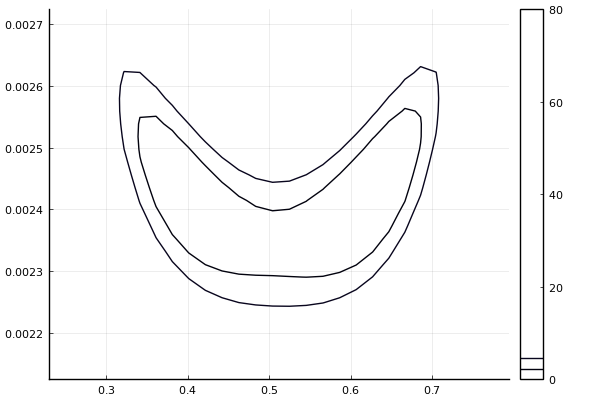

In [74]:
contour(sin.(theta23s).^2, dms .-params[:Δm²₂₁], 2. .*(maximum(llhs).-llhs), levels=quantile(Chisq(2), [0.68, 0.9]))

In [67]:
params[:Δm²₂₁]

7.53e-5